In [1]:
# Import modules for OpenServer functions
import win32com.client
import win32com
import sys
import time
import random
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
from tqdm import tqdm
# Import input distributions as required
from scipy.stats import truncnorm
from scipy.stats import triang
from scipy.stats import uniform
import plotly.express as px
import plotly.graph_objects as go
from plotly.colors import n_colors
from datetime import datetime as dt
from calendar import monthrange
import itertools
from itertools import permutations
import gc

In [2]:
class OpenServer():
    "Class for holding ActiveX reference. Allows license disconnection"
    def __init__(self):
        self.status = "Disconnected"
        self.OSReference = None
    
    def Connect(self):
        self.OSReference = win32com.client.Dispatch("PX32.OpenServer.1")
        self.status = "Connected"
        print("OpenServer connected")
        
    def Disconnect(self):
        self.OSReference = None
        self.status = "Disconnected"
        print("OpenServer disconnected")


def GetAppName(sv):
    # function for returning app name from tag string
    pos = sv.find(".")
    if pos < 2:
        sys.exit("GetAppName: Badly formed tag string")
    app_name = sv[:pos]
    if app_name.lower() not in ["prosper", "mbal", "gap", "pvt", "resolve",
                                   "reveal"]:
        sys.exit("GetAppName: Unrecognised application name in tag string")
    return app_name


def DoCmd(OpenServe, cmd):
    # perform a command and check for errors
    lerr = OpenServe.OSReference.DoCommand(cmd)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoCmd: " + err)


def DoSet(OpenServe, sv, val):
    # set a value and check for errors
    lerr = OpenServe.OSReference.SetValue(sv, val)
    app_name = GetAppName(sv)
    lerr = OpenServe.OSReference.GetLastError(app_name)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoSet: " + err)
    
def DoGet(OpenServe, gv):
    # get a value and check for errors
    get_value = OpenServe.OSReference.GetValue(gv)
    app_name = GetAppName(gv)
    lerr = OpenServe.OSReference.GetLastError(app_name)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoGet: " + err)
    return get_value


def DoSlowCmd(OpenServe, cmd):
    # perform a command then wait for command to exit and check for errors
    step = 0.001
    app_name = GetAppName(cmd)
    lerr = OpenServe.OSReference.DoCommandAsync(cmd)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoSlowCmd: " + err)
    while OpenServe.OSReference.IsBusy(app_name) > 0:
        if step < 2:
            step = step*2
        time.sleep(step)
    lerr = OpenServe.OSReference.GetLastError(app_name)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoSlowCmd: " + err)


def DoGAPFunc(OpenServe, gv):
    DoSlowCmd(gv)
    DoGAPFunc = DoGet(OpenServe, "GAP.LASTCMDRET")
    lerr = OpenServe.OSReference.GetLastError("GAP")
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoGAPFunc: " + err)
    return DoGAPFunc


def OSOpenFile(OpenServe, theModel, appname):
    DoSlowCmd(OpenServe, appname + '.OPENFILE ("' + theModel + '")')
    lerr = OpenServe.OSReference.GetLastError(appname)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("OSOpenFile: " + err)


def OSSaveFile(OpenServe, theModel, appname):
    DoSlowCmd(OpenServe, appname + '.SAVEFILE ("' + theModel + '")')
    lerr = OpenServe.OSReference.GetLastError(appname)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("OSSaveFile: " + err)
        



### Define range of sensitivities

In [3]:
# Change directory to well models folder
os.chdir(r'C:\prosper\openserver_with_python\models5')

In [4]:
cwd = os.getcwd()
wellmodels = os.listdir()
wells = [wellmodel[4:].split('.')[0] for wellmodel in wellmodels]
print("here is the list of the wells:")
wells

here is the list of the wells:


['_1', '_2', '_3', '_4', '_5']

In [5]:
Gavail = float(input("How  much of Gas is available?: ",))
Step = float(input("How big the step you want to use?: ",))
GL_range = np.arange(0,Gavail+Step,Step)
GL_range = [round(float(GL),3) for  GL in GL_range]
print(GL_range)

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5]


In [6]:
def GasLift(wellmodel):
    try:
        # Initialises an 'OpenServer' class

        petex = OpenServer()

        # Creates ActiveX reference and holds a license

        petex.Connect()


        # Perform functions

        OSOpenFile(petex, cwd + r'/'+ wellmodel, 'PROSPER')

        # Clear all cases
        DoSet(petex,"PROSPER.ANL.SYS.Sens.SensDB.Clear", 0)  

        # Define Gas Injection Rate as a case
        DoSet(petex,"PROSPER.ANL.SYS.Sens.SensDB.Vars[0]",22)
        for i,GL in enumerate(GL_range):
             DoSet(petex,"PROSPER.ANL.SYS.Sens.SensDB.Sens[138].Vals["+str(i)+"]",GL)

        DoCmd(petex, 'PROSPER.ANL.SYS.CALC')

        # Pick the calculated values
        OPR_result = []
        for i in range(len(GL_range)):
            OPR = DoGet(petex, 'PROSPER.OUT.SYS.Results['+str(i)+'].Sol.OilRate')
            OPR = round(float(OPR),2)
            OPR_result.append(OPR)

    finally:
        # Required to close the license otherwise remains checked out

        petex.Disconnect()
    return list(zip(OPR_result, GL_range))

In [7]:
for i, wellmodel in enumerate(wellmodels):
    wells[i] = GasLift(wellmodel)

OpenServer connected
OpenServer disconnected
OpenServer connected
OpenServer disconnected
OpenServer connected
OpenServer disconnected
OpenServer connected
OpenServer disconnected
OpenServer connected
OpenServer disconnected


In [8]:
## Cut the data to the maximum
for i in range(len(wells)):
    max_index = wells[i].index(max(wells[i]))
    if max_index < len(wells[i]): max_index += 1
    wells[i] = wells[i][:max_index]

In [9]:
len(wells)

5

In [10]:
wells

[[(1749.18, 0.0),
  (1759.44, 0.1),
  (1767.97, 0.2),
  (1775.18, 0.3),
  (1781.27, 0.4),
  (1786.37, 0.5),
  (1790.62, 0.6),
  (1794.11, 0.7),
  (1796.92, 0.8),
  (1799.13, 0.9),
  (1800.78, 1.0),
  (1801.88, 1.1),
  (1802.44, 1.2),
  (1802.58, 1.3)],
 [(1657.35, 0.0),
  (1668.4, 0.1),
  (1677.71, 0.2),
  (1685.58, 0.3),
  (1692.24, 0.4),
  (1697.85, 0.5),
  (1702.57, 0.6),
  (1706.89, 0.7),
  (1710.09, 0.8),
  (1712.6, 0.9),
  (1714.54, 1.0),
  (1715.98, 1.1),
  (1716.94, 1.2),
  (1717.44, 1.3),
  (1717.55, 1.4)],
 [(1576.44, 0.0),
  (1588.09, 0.1),
  (1597.9, 0.2),
  (1606.21, 0.3),
  (1613.28, 0.4),
  (1619.15, 0.5),
  (1623.94, 0.6),
  (1630.42, 0.7),
  (1633.8, 0.8),
  (1636.59, 0.9),
  (1638.84, 1.0),
  (1640.6, 1.1),
  (1641.92, 1.2),
  (1642.82, 1.3),
  (1643.34, 1.4),
  (1643.5, 1.5)],
 [(1362.42, 0.0),
  (1375.9, 0.1),
  (1387.41, 0.2),
  (1397.28, 0.3),
  (1405.79, 0.4),
  (1413.16, 0.5),
  (1419.53, 0.6),
  (1425.0, 0.7),
  (1431.86, 0.8),
  (1435.76, 0.9),
  (1438.99, 1.0

In [11]:
wells[4]

[(997.05, 0.0),
 (1013.68, 0.1),
 (1027.6, 0.2),
 (1041.02, 0.3),
 (1051.22, 0.4),
 (1060.09, 0.5),
 (1067.58, 0.6),
 (1074.09, 0.7),
 (1079.76, 0.8),
 (1085.05, 0.9),
 (1089.13, 1.0),
 (1092.54, 1.1),
 (1095.47, 1.2),
 (1097.91, 1.3),
 (1099.84, 1.4),
 (1101.44, 1.5),
 (1102.61, 1.6),
 (1103.48, 1.7),
 (1103.99, 1.8),
 (1104.21, 1.9)]

In [12]:
combination = list(itertools.product(*wells))

In [13]:
combination

[((1749.18, 0.0),
  (1657.35, 0.0),
  (1576.44, 0.0),
  (1362.42, 0.0),
  (997.05, 0.0)),
 ((1749.18, 0.0),
  (1657.35, 0.0),
  (1576.44, 0.0),
  (1362.42, 0.0),
  (1013.68, 0.1)),
 ((1749.18, 0.0),
  (1657.35, 0.0),
  (1576.44, 0.0),
  (1362.42, 0.0),
  (1027.6, 0.2)),
 ((1749.18, 0.0),
  (1657.35, 0.0),
  (1576.44, 0.0),
  (1362.42, 0.0),
  (1041.02, 0.3)),
 ((1749.18, 0.0),
  (1657.35, 0.0),
  (1576.44, 0.0),
  (1362.42, 0.0),
  (1051.22, 0.4)),
 ((1749.18, 0.0),
  (1657.35, 0.0),
  (1576.44, 0.0),
  (1362.42, 0.0),
  (1060.09, 0.5)),
 ((1749.18, 0.0),
  (1657.35, 0.0),
  (1576.44, 0.0),
  (1362.42, 0.0),
  (1067.58, 0.6)),
 ((1749.18, 0.0),
  (1657.35, 0.0),
  (1576.44, 0.0),
  (1362.42, 0.0),
  (1074.09, 0.7)),
 ((1749.18, 0.0),
  (1657.35, 0.0),
  (1576.44, 0.0),
  (1362.42, 0.0),
  (1079.76, 0.8)),
 ((1749.18, 0.0),
  (1657.35, 0.0),
  (1576.44, 0.0),
  (1362.42, 0.0),
  (1085.05, 0.9)),
 ((1749.18, 0.0),
  (1657.35, 0.0),
  (1576.44, 0.0),
  (1362.42, 0.0),
  (1089.13, 1.0)),
 

In [29]:
GL_sum = [list(map(sum, zip(*list(comb))))[1] for  comb  in  combination]
GL_sum

[0.0,
 0.1,
 0.2,
 0.3,
 0.4,
 0.5,
 0.6,
 0.7,
 0.8,
 0.9,
 1.0,
 1.1,
 1.2,
 1.3,
 1.4,
 1.5,
 1.6,
 1.7,
 1.8,
 1.9,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6,
 0.7,
 0.7999999999999999,
 0.9,
 1.0,
 1.1,
 1.2000000000000002,
 1.3,
 1.4000000000000001,
 1.5,
 1.6,
 1.7000000000000002,
 1.8,
 1.9000000000000001,
 2.0,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7,
 0.8,
 0.8999999999999999,
 1.0,
 1.1,
 1.2,
 1.3,
 1.4,
 1.5,
 1.5999999999999999,
 1.7,
 1.8,
 1.9,
 2.0,
 2.1,
 0.3,
 0.4,
 0.5,
 0.6,
 0.7,
 0.8,
 0.8999999999999999,
 1.0,
 1.1,
 1.2,
 1.3,
 1.4000000000000001,
 1.5,
 1.6,
 1.7,
 1.8,
 1.9000000000000001,
 2.0,
 2.1,
 2.1999999999999997,
 0.4,
 0.5,
 0.6000000000000001,
 0.7,
 0.8,
 0.9,
 1.0,
 1.1,
 1.2000000000000002,
 1.3,
 1.4,
 1.5,
 1.6,
 1.7000000000000002,
 1.7999999999999998,
 1.9,
 2.0,
 2.1,
 2.2,
 2.3,
 0.5,
 0.6,
 0.7,
 0.8,
 0.9,
 1.0,
 1.1,
 1.2,
 1.3,
 1.4,
 1.5,
 1.6,
 1.7,
 1.8,
 1.9,
 2.0,
 2.1,
 2.2,
 2.3,
 2.4,
 0.6,
 0

In [31]:
true_indeces = [i for i,GL in enumerate(GL_sum) if GL<=Gavail]

In [32]:
GL_selected = [combination[i] for i in true_indeces]

In [33]:
Rate_sum = [list(map(sum, zip(*list(selected))))[0] for selected  in  GL_selected]

In [34]:
Rate_Max = max(Rate_sum)

In [35]:
GL_selected[Rate_sum.index(Rate_Max )]

((1786.37, 0.5),
 (1702.57, 0.6),
 (1630.42, 0.7),
 (1431.86, 0.8),
 (1085.05, 0.9))

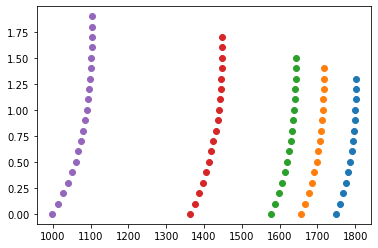

In [37]:
plt.scatter((*zip(*wells[0])))
plt.scatter((*zip(*wells[1])))
plt.scatter((*zip(*wells[2])))
plt.scatter((*zip(*wells[3])))
plt.scatter((*zip(*wells[4])))

plt.show()

In [192]:
a = wells[0]
b = wells[1]
c = wells[2]
d = wells[3]

In [193]:
def compare_floats(float_num, prec = 5):
    return int(float_num*10**5)

from operator import itemgetter
LL = [a, b, c,d] #, c, d, ...]
tgt_sum_1 = 2

lenLL = len(LL)
maxIndx_LL = lenLL-1
maxIndx_l_inLL = []

for l in LL: 
   l.sort(key=itemgetter(1), reverse=True)
   maxIndx_l_inLL.append(len(l)-1)
#print( LL )

indx_tpl_of_l_inLL = [0]*lenLL
#print(indx_tpl_of_l_inLL, maxIndx_l_inLL)
max_sum_0 = 0.0
indx_tpl_of_l_inLL_for_max_sum = None
import time

indx_to_increase = lenLL-1
while indx_tpl_of_l_inLL[0] <= maxIndx_l_inLL[0]:
    print(indx_tpl_of_l_inLL, end=' # ')
    sum_1 = 0.0
    increase_indx_only = False
    time.sleep(0.25)
    for i in range(lenLL):
        sum_1 += LL[i][indx_tpl_of_l_inLL[i]][1]
        if compare_floats(sum_1) > compare_floats(tgt_sum_1):
            indx_to_increase = i
            increase_indx_only = True
            break

    print(sum_1, tgt_sum_1, end=' ## ')
    if increase_indx_only:
        print(f'{indx_to_increase=}')

    if not increase_indx_only and compare_floats(sum_1) < compare_floats(tgt_sum_1):
        indx_tpl_of_l_inLL[indx_to_increase] = maxIndx_l_inLL[indx_to_increase]
        print('sum_1 < tgt_sum_1 ', indx_tpl_of_l_inLL)
        increase_indx_only = True 

    if not increase_indx_only:
        print('sum_1 == tgt_sum_1', indx_tpl_of_l_inLL)
        assert compare_floats(sum_1) == compare_floats(tgt_sum_1)
        if indx_tpl_of_l_inLL_for_max_sum is None: 
            indx_tpl_of_l_inLL_for_max_sum = [indx_tpl_of_l_inLL]
            max_sum = sum(LL[i][indx_tpl_of_l_inLL[i]][0] for i in range(lenLL))
            print(f'max_sum={max_sum} at {indx_tpl_of_l_inLL}')
        else:
            cur_sum = sum(LL[i][indx_tpl_of_l_inLL[i]][0] for i in range(lenLL))
            if compare_floats(cur_sum) == compare_floats(max_sum): 
                indx_tpl_of_l_inLL_for_max_sum += [indx_tpl_of_l_inLL[:]] # [:] make a copy
            elif compare_floats(cur_sum) > compare_floats(max_sum):
                indx_tpl_of_l_inLL_for_max_sum = [indx_tpl_of_l_inLL[:]]
                max_sum = cur_sum
                print(f'new max_sum={max_sum} at {indx_tpl_of_l_inLL}')

    while indx_tpl_of_l_inLL[indx_to_increase] == maxIndx_l_inLL[indx_to_increase]:
        indx_tpl_of_l_inLL[indx_to_increase] = 0
        indx_to_increase -= 1

    if indx_to_increase < 0: 
        break

    indx_tpl_of_l_inLL[indx_to_increase] += 1
    indx_to_increase = lenLL-1

print('---------------------------')
print([ LL[i][j] for i, j in enumerate(indx_tpl_of_l_inLL_for_max_sum[0])], max_sum, indx_tpl_of_l_inLL_for_max_sum)

[0, 0, 0, 0] # 2.1 2 ## indx_to_increase=2
[0, 0, 1, 0] # 3.3 2 ## indx_to_increase=3
[0, 0, 1, 1] # 3.2 2 ## indx_to_increase=3
[0, 0, 1, 2] # 3.1 2 ## indx_to_increase=3
[0, 0, 1, 3] # 3.0 2 ## indx_to_increase=3
[0, 0, 1, 4] # 2.9 2 ## indx_to_increase=3
[0, 0, 1, 5] # 2.8 2 ## indx_to_increase=3
[0, 0, 1, 6] # 2.7 2 ## indx_to_increase=3
[0, 0, 1, 7] # 2.6 2 ## indx_to_increase=3
[0, 0, 1, 8] # 2.5 2 ## indx_to_increase=3
[0, 0, 1, 9] # 2.4 2 ## indx_to_increase=3
[0, 0, 1, 10] # 2.3 2 ## indx_to_increase=3
[0, 0, 1, 11] # 2.2 2 ## indx_to_increase=3
[0, 0, 1, 12] # 2.1 2 ## indx_to_increase=3
[0, 0, 1, 13] # 2.0 2 ## sum_1 == tgt_sum_1 [0, 0, 1, 13]
max_sum=552.55 at [0, 0, 1, 13]
[0, 0, 2, 0] # 3.2 2 ## indx_to_increase=3
[0, 0, 2, 1] # 3.0999999999999996 2 ## indx_to_increase=3
[0, 0, 2, 2] # 3.0 2 ## indx_to_increase=3
[0, 0, 2, 3] # 2.9 2 ## indx_to_increase=3
[0, 0, 2, 4] # 2.8 2 ## indx_to_increase=3
[0, 0, 2, 5] # 2.7 2 ## indx_to_increase=3
[0, 0, 2, 6] # 2.599999999999999

KeyboardInterrupt: 

In [ ]:
# Custom function for performing PROSPER calculation
def calc_OPR(OpenServe, p, wc, gor):
    DoSet(OpenServe, "PROSPER.SIN.IPR.Single.Pres", p)
    DoSet(OpenServe, "PROSPER.ANL.SYS.WC", wc)
    DoSet(OpenServe, "PROSPER.ANL.SYS.GOR", gor)
    DoCmd(OpenServe, "PROSPER.ANL.SYS.CALC")
    OPR = DoGet(OpenServe, "PROSPER.OUT.SYS.Results[0].Sol.OilRate")
    if float(OPR) > 10:
        OPR = round(float(OPR),2) 
    else:
        OPR = 0    
    return OPR

In [ ]:
os.getcwd()

In [ ]:
os.chdir(r'X:\D18 Phase 2\Technical\Ptech\D18 Network Model\PROSPER\GLC VLP\Model')

In [ ]:
models = os.listdir()

In [ ]:
DoSet("PROSPER.ANL.SYS.Sens.SensDB.Clear")

In [ ]:
PROSPER.ANL.SYS.Sens.SensDB.Vars[0]	22	    Gaslift Gas Injection Rate (index = 138)

In [ ]:
PROSPER.ANL.SYS.Sens.SensDB.Sens[138].Vals[0]